In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re
import copy
import seaborn as sns
from itertools import product
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
from utils import *
from plots import *
import pickle 
from Bio.Seq import Seq
import scipy.stats as ss
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

### Align nanopore sequencing data

In [27]:
sample = "HJR312_1" #"HJR312_2"

# Create a dictionary for reference regions
ref_range_dict = {
    "HJR312" : ('chr9', 133002683, 133005465)
}   
locus = "HJR312"

# Create folder for saving plots
plot_dir = "/home/yanhu/data/DddA/HJR312/plots/" + sample
if not os.path.exists(plot_dir):
    os.system("mkdir -p " + plot_dir)
    
# If we have already aligned reads before, load the saved ddda_data object
save_path = f"/home/yanhu/data/DddA/HJR312/ddda_data_{sample}.pkl"
if os.path.exists(save_path):
    with open(save_path, "rb") as f:
        ddda_data = pickle.load(f)
else:
        
    # Initialize ddda_dataset
    ddda_data = ddda_dataset(
        ID = sample, 
        region_dict = ref_range_dict, 
        genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
        fastq_file = f"/home/yanhu/data/DddA/HJR312/fastqs/{sample}_merged.fastq.gz", 
        working_dir = f"/home/yanhu/data/DddA/HJR312/"
    )
    
    # Load DddA bias model
    with open("/home/yanhu/data/DddA/HJR245/bias_dict.pkl", "rb") as f:
        ddda_data.bias_model = pickle.load(f)
    
    # Align reads
    gap_threshold = 500
    ddda_data.align_reads(
        start_gap_threshold = gap_threshold,
        end_gap_threshold = gap_threshold
    )
    
    with open(save_path, "wb") as f:
        pickle.dump(ddda_data, f)

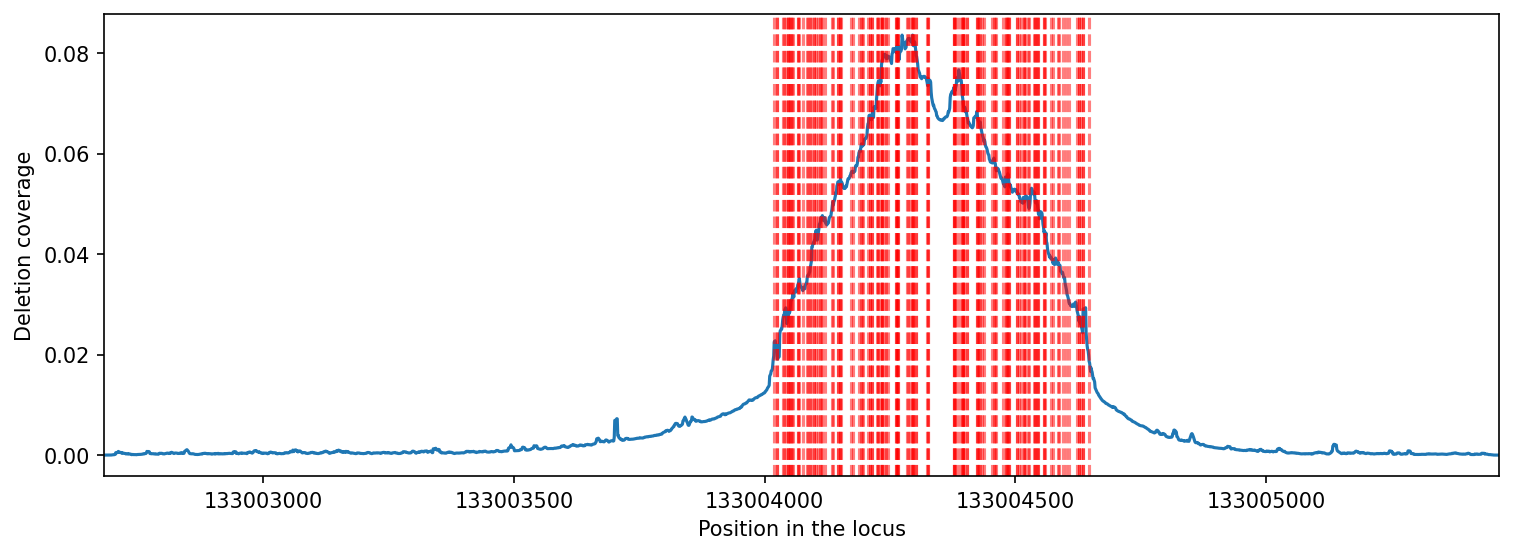

In [28]:
# Load sgRNA sequences
sgRNAs = pd.read_csv("/home/yanhu/data/DddA/HJR312/sgRNA.tsv", sep="\t", header=None)
sgRNAs.columns = ["ID", "sequence"]

# Get sequence of the target locus
ref_seq = ddda_data.ref_seq_dict[locus]

# Find sgRNA positions in the target locus
cut_sites = []
for i, row in sgRNAs.iterrows():
    guide_seq_forward = row["sequence"].upper()
    guide_seq_reverse = str(Seq(guide_seq_forward).reverse_complement())
    forward_match = ref_seq.find(guide_seq_forward)
    reverse_match = ref_seq.find(guide_seq_reverse)
    if forward_match >= 0 and reverse_match == -1:
        cut_site = forward_match + len(guide_seq_forward) - 3 # Cas9 cuts at the 3rd to last base
    elif forward_match == -1 and reverse_match >= 0:
        cut_site = reverse_match + 3
    else:
        raise ValueError("No match for sgRNA found in the target locus")
    cut_sites.append(cut_site)

# Sort sgRNA cut sites by coordinate
cut_sites = sorted(cut_sites)

# Visualize deletion coverage and sgRNA positions
del_matrix = ddda_data.del_dict[locus]
del_coverage = np.array(np.mean(del_matrix, axis=0))[0]
region_start, region_end = ref_range_dict[locus][1], ref_range_dict[locus][2] + 1
plt.figure(dpi=150, figsize=(12, 4))
plt.plot(np.arange(region_start, region_end), del_coverage)
for cut_site in cut_sites:
    plt.axvline(x = cut_site + region_start, color="red", linestyle="dashed", alpha=0.5)
plt.ylabel("Deletion coverage")
plt.xlabel("Position in the locus")
plot_start, plot_end = 133002683, 133005465
plt.xlim([plot_start, plot_end])
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0), useOffset=False)
plt.savefig(os.path.join(plot_dir, "sgRNA_deletion_coverage_" + sample + "_" + \
                         str(plot_start) + "_" + str(plot_end) + ".pdf"))
plt.show()